# Imports

In [284]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import svm, preprocessing, tree
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split, TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
import warnings
warnings.filterwarnings("ignore")
from sklearn.svm import LinearSVR
from sklearn.linear_model import Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from regressors import stats

In [306]:
%run config.ipynb

# Data

In [2]:
df = pd.DataFrame(np.load(r'../data/master_prepared.npy', allow_pickle=True))
cols = np.load(r'../data/columns_prepared.npy', allow_pickle=True)
df.columns = cols

In [3]:
drop_cols = [
    'date',
    'eligible',
    'companyid', 
    'ret_1f1',
    'ret_1f3',
    'ret_1f6',
    'ret_1f12',
    'retxs_1f1',
    'retxs_1f3',
    'retxs_1f6',
    'retxs_1f12'
]

y_col = 'ret_1f1'

# X cols are the independent variables
x_cols = [i for i in list(df.columns) if i not in drop_cols]

companies = df['companyid'].unique()
dates = df['date'].unique()

# Only use eligible data
df_eligible = df[df['eligible']==1]
X = df_eligible[x_cols].astype('float64')
y = df_eligible[y_col].astype('float64')
for col in ['companyid', 'date']:
    X.insert(0, col, df_eligible[col])


# Models Setup

In [322]:
cv = 5
scoring = 'r2'

setups_decomp = ['FF3_','FF5_','mom_','vol_', 'combined_'] # Add * for nonlinear versions
setups_pred = ['FF3','FF5','mom','vol', 'combined'] # Add * for nonlinear versions
models = {
    'OLS':LinearRegression(),
#     'Polynomial':LinearRegression(), 
    'Lasso':Lasso(alpha=2),
    'Ridge':Ridge(alpha=2),
    'Tree':DecisionTreeRegressor(max_depth=2)
}

# Cross Validation Methods

In [323]:
# Put results in a table
def kfold_test_model(model, setup, cv, scoring):
    perf = np.mean(cross_val_score(estimator=model, X=X[predictor_sets[setup]], y=y, scoring=scoring, cv=cv))
    return perf

def rolling_origin_validation(model, setup, n_splits, scoring):
    
    X_ = X[predictor_sets[setup]]
    y_ = y
    
    splits = TimeSeriesSplit(n_splits=n_splits)
    
    scorers = {'r2':r2_score, 'mean_squared_error':mean_squared_error}
    
    perf_vals = []
    
    for train_index, test_index in splits.split(X_):

        X_train = X_.loc[train_index]
        X_test = X_.loc[test_index]
        y_train = y_.loc[train_index]
        y_test = y_.loc[test_index]

        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        perf_val = scorers[scoring](y_test, pred)
        
        perf_vals.append(perf_val)
        
    return np.mean(perf_vals)

### K Fold Cross Validation

In [324]:
kfold_table_decomp = pd.DataFrame(index= setups_decomp, columns=models)

for s in setups_decomp:
    for m in list(models.keys()):
#         if m != 'Linear':
#             s_ = s + '*'
#         else:
        s_ = s
            
        kfold_table_decomp[m].loc[s] = round(kfold_test_model(models[m], s_, cv, scoring), 3)

kfold_table_decomp

,OLS,Lasso,Ridge,Tree
FF3_,-0.031,-0.003,-0.03,-0.005
FF5_,0.038,-0.003,0.039,0.013
mom_,-0.005,-0.003,-0.005,-0.015
vol_,0.056,-0.003,0.057,0.032
combined_,0.061,-0.003,0.062,0.024


In [129]:
kfold_table_decomp[kfold_table_decomp>0].fillna('-')

,Linear,Polynomial,Lasso,Ridge,Tree
FF3_,-,-,-,-,-
FF5_,0.038,-,-,0.042,0.017
mom_,-,-,-,-,-
vol_,0.056,-,-,0.054,0.029
combined_,0.061,-,-,0.058,0.021


In [124]:
kfold_table_pred = pd.DataFrame(index= setups_pred, columns=models)

for s in setups_pred:
    for m in list(models.keys()):
        if m != 'Linear':
            s_ = s + '*'
        else:
            s_ = s
            
        val = kfold_test_model(models[m], s_, cv, scoring)
        kfold_table_pred[m].loc[s] = round(val, 3)

kfold_table_pred

,Linear,Polynomial,Lasso,Ridge,Tree
FF3,-0.001,-0,-0.002,-0,-0.005
FF5,-0.004,-0.246,-0.337,-0.246,0.011
mom,-0.001,-2.932,-0.002,-5.445,-0.033
vol,-0.003,-0.018,-0.002,-0.02,-0.006
combined,-0.115,-0.325,-0.482,-0.816,-0.001


### Rolling Origin Evaluation

In [130]:
ts_table_decomp = pd.DataFrame(index= setups_decomp, columns=models.keys())

for s in setups_decomp:
    for m in list(models.keys()):
        if m != 'Linear':
            s_ = s + '*'
        else:
            s_ = s
            
        val = rolling_origin_validation(model=models[m], setup=s_, n_splits=cv, scoring='r2')
        ts_table_decomp[m].loc[s] = round(val, 3)

ts_table_decomp

,Linear,Polynomial,Lasso,Ridge,Tree
FF3_,-0.014,-0.042,-0.001,-0.026,-0.026
FF5_,0.033,-0.658,-0.001,0.024,0.008
mom_,0.005,-0.598,-0.001,0.009,0.006
vol_,0.056,-0.333,-0.001,0.057,0.017
combined_,0.06,-0.426,-0.001,0.057,0.003


In [126]:
ts_table_pred = pd.DataFrame(index= setups_pred, columns=models.keys())

for s in setups_pred:
    for m in list(models.keys()):
        if m != 'Linear':
            s_ = s + '*'
        else:
            s_ = s
            
        val = rolling_origin_validation(model=models[m], setup=s_, n_splits=cv, scoring='r2')
        ts_table_pred[m].loc[s] = val

ts_table_pred

,Linear,Polynomial,Lasso,Ridge,Tree
FF3,-0.000748763,-0.00621547,-0.000851356,-0.00621727,-0.446659
FF5,-0.00432304,-55.6368,-28.4749,-55.6293,0.00446691
mom,-0.00487106,-0.0179976,-0.000833884,-0.00976568,-0.00521929
vol,-0.00369631,-0.0321228,-0.000851356,-0.0343786,-0.00541267
combined,-0.147229,-34.4728,-73.0188,-252.521,-0.037438


In [127]:
ts_table_pred[ts_table_pred>0].fillna('-')

,Linear,Polynomial,Lasso,Ridge,Tree
FF3,-,-,-,-,-
FF5,-,-,-,-,0.00446691
mom,-,-,-,-,-
vol,-,-,-,-,-
combined,-,-,-,-,-


# K-Fold CV Graphs

In [16]:
cv_testing_table = pd.DataFrame(index= [3, 5, 10, 15, 20, 30, 50], columns=models.keys())

s = 'FF5_'
cv_score_measure = 'neg_mean_squared_error'
for i in list(cv_testing_table.index):
    for m in list(models.keys()):
        if m != 'Linear':
            s_ = s + '*'
        else:
            s_ = s
        
        if cv_score_measure == 'neg_mean_squared_error':
            mult = -1
        else:
            mult = 1
            
        val = kfold_test_model(model=models[m], setup=s_, cv=i, scoring=cv_score_measure)
        cv_testing_table[m].loc[i] = val * mult # Because we are measuring negative mean squared error

cv_testing_table

,Linear,Polynomial,Lasso,Ridge,Tree
3,0.0170938,0.0243183,0.0175235,0.0169984,0.0172901
5,0.0166407,0.0181326,0.0175373,0.0165671,0.0170619
10,0.0165779,0.0174202,0.0175462,0.0165357,0.0173032
15,0.0165723,0.0184669,0.0175549,0.0165742,0.0170604
20,0.0165532,0.0190979,0.0175508,0.0165457,0.017044
30,0.0164862,0.0170474,0.0175628,0.01663,0.0170667
50,0.0164773,0.016751,0.0175523,0.01664,0.0170833


Text(0, 0.5, 'Mean Squared Error')

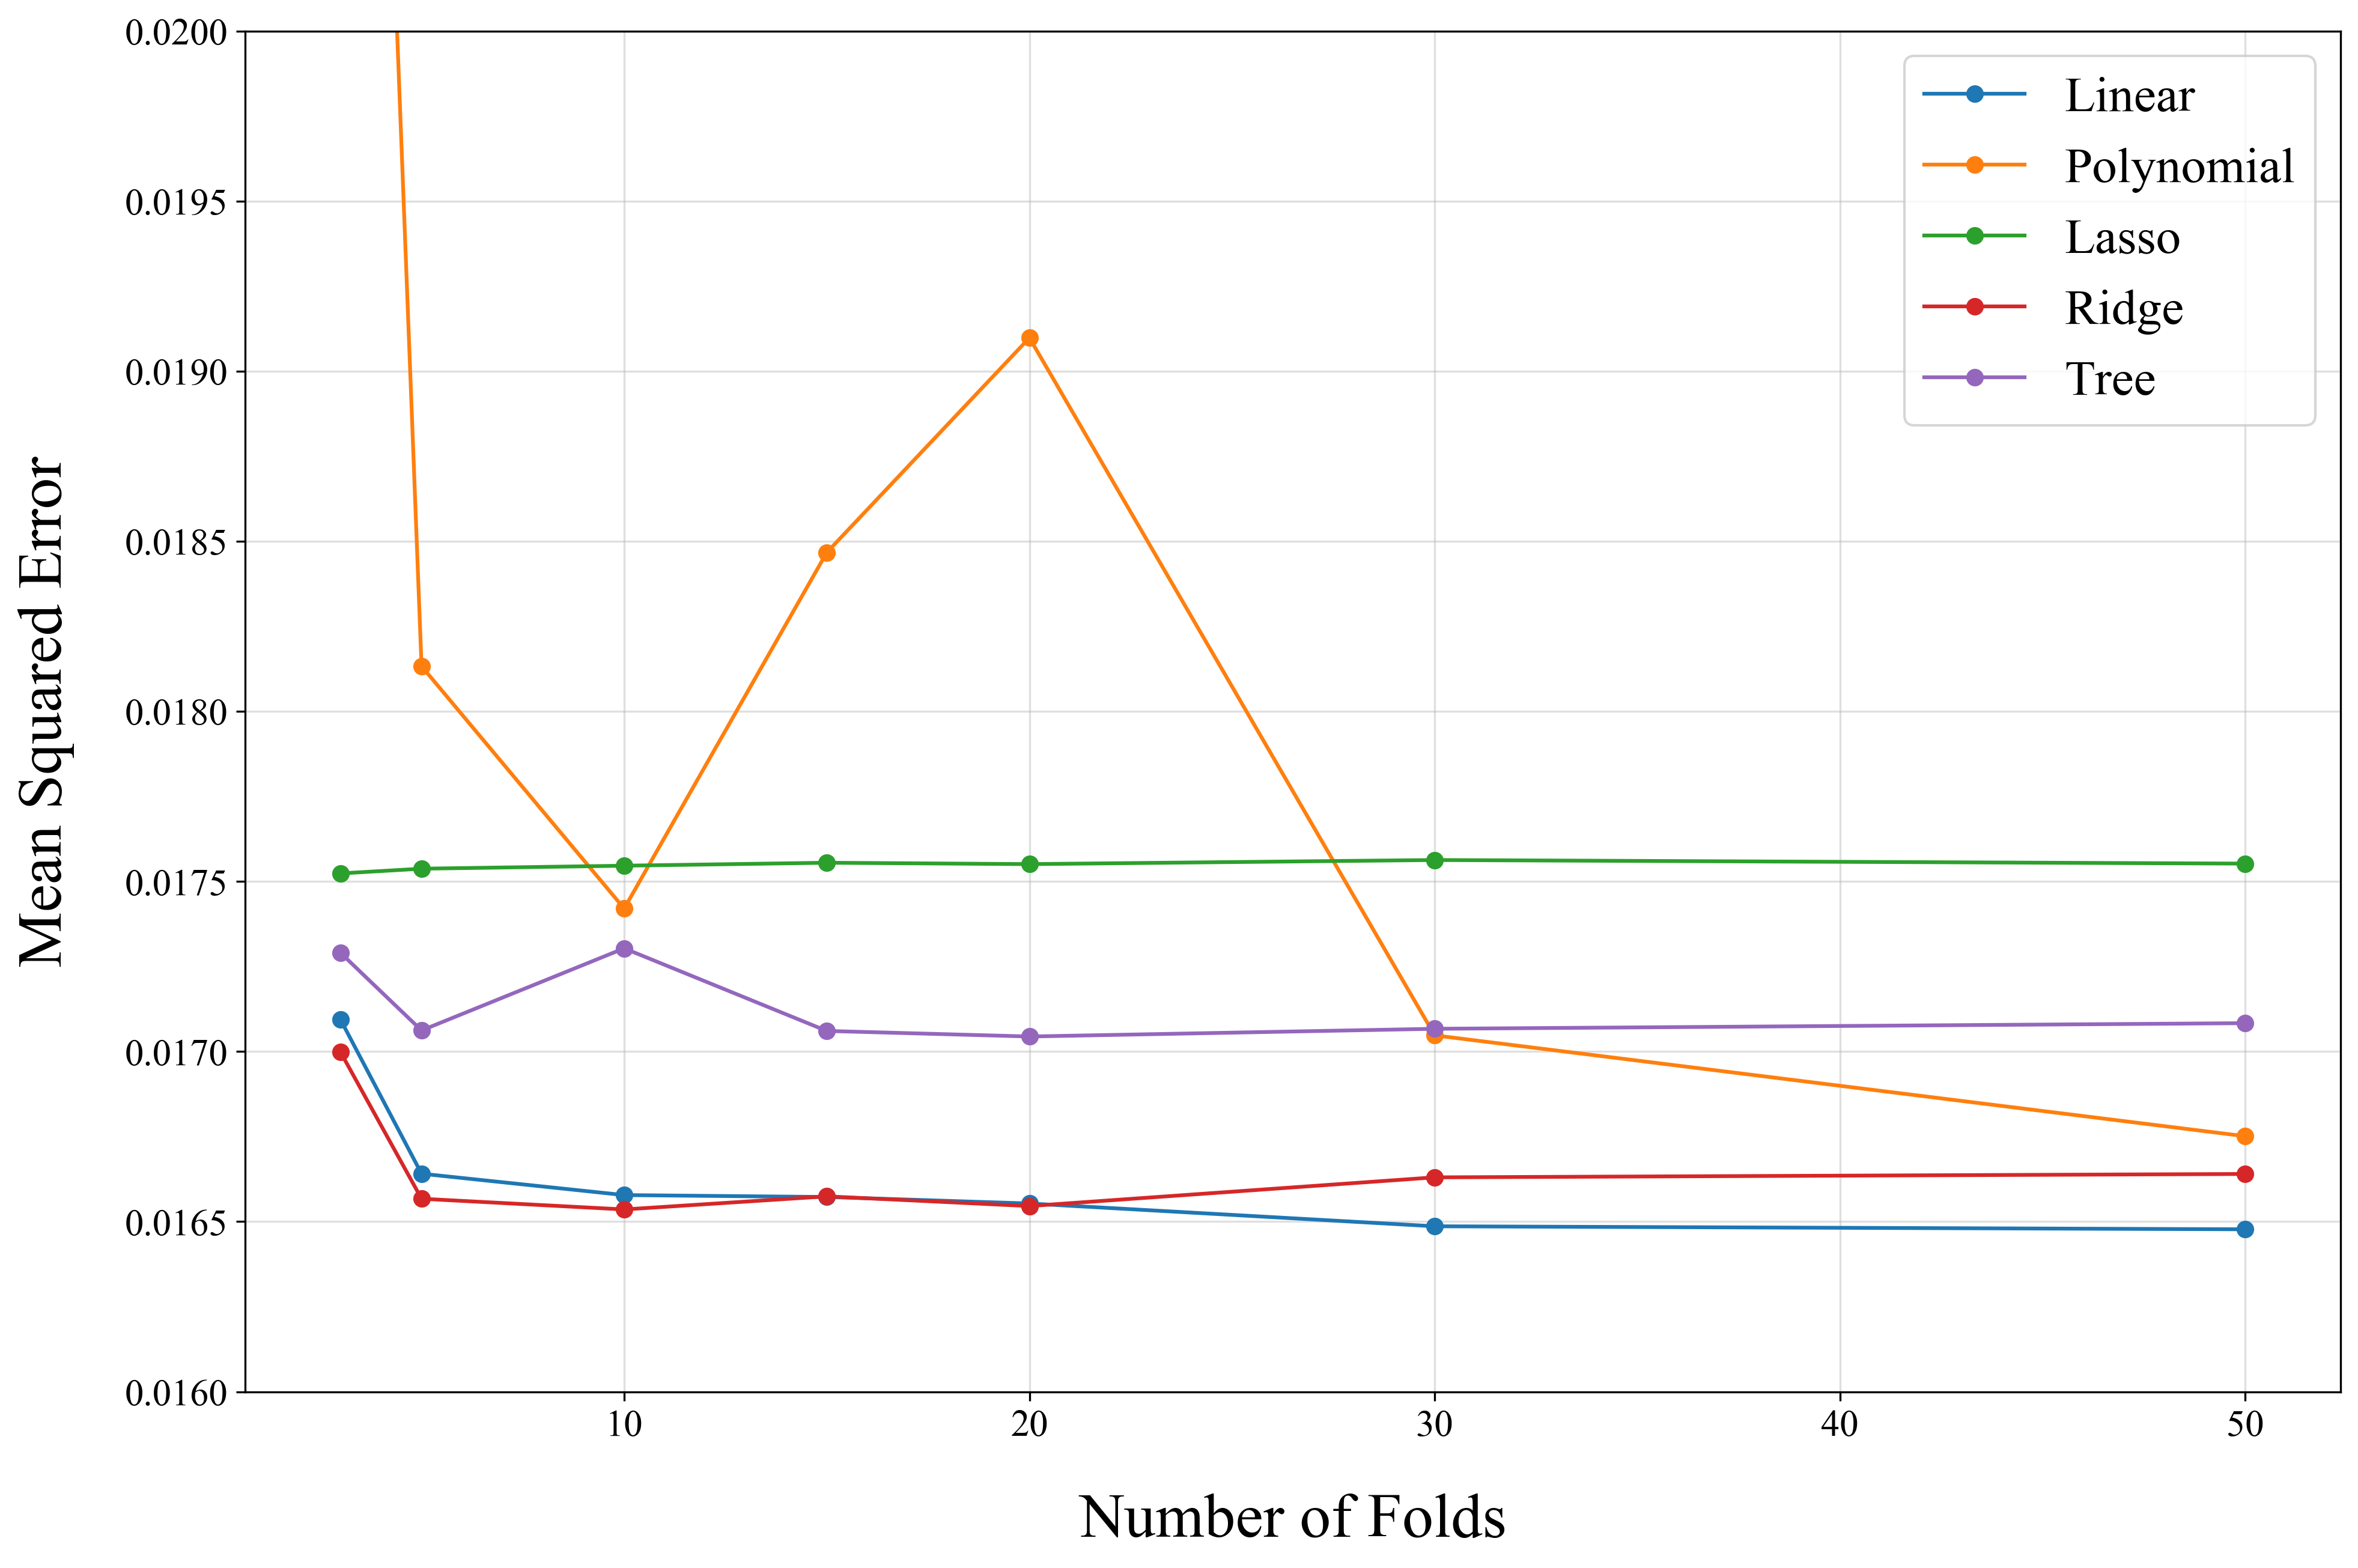

In [307]:
fig, ax = plt.subplots(figsize=[15,10])
ax.set_ylim(0.016, 0.02)
ax.plot(cv_testing_table, marker='o')
ax.legend(cv_testing_table.columns)
ax.set_xlabel('Number of Folds')
ax.set_ylabel('Mean Squared Error')


# Rolling Origin Evaluation Graphs

In [18]:
ro_testing_table = pd.DataFrame(index= [3, 5, 10, 15, 20, 30, 50], columns=models.keys())

s = 'combined_'
for i in list(ro_testing_table.index):
    for m in list(models.keys()):
        if m != 'Linear':
            s_ = s + '*'
        else:
            s_ = s
            
        val = rolling_origin_validation(model=models[m], setup=s_, n_splits=i, scoring='mean_squared_error')
        ro_testing_table[m].loc[i] = val

ro_testing_table

,Linear,Polynomial,Lasso,Ridge,Tree
3,0.0130256,0.0169061,0.0142599,0.0130809,0.0137386
5,0.0144498,0.0264009,0.0158983,0.0144908,0.0153396
10,0.0147206,2.87007e+20,0.0162031,0.0147327,0.0152907
15,0.0154148,5.17817e+20,0.0167746,0.015354,0.0160186
20,0.0173054,9.5171e+20,0.0175979,0.0169491,0.0168241
30,1.18932e+23,9.88113e+22,0.0175904,0.0166742,0.0167253
50,2.39417e+23,1.25054e+22,0.0175441,0.0162388,0.0166264


Text(0, 0.5, 'Mean Squared Error')

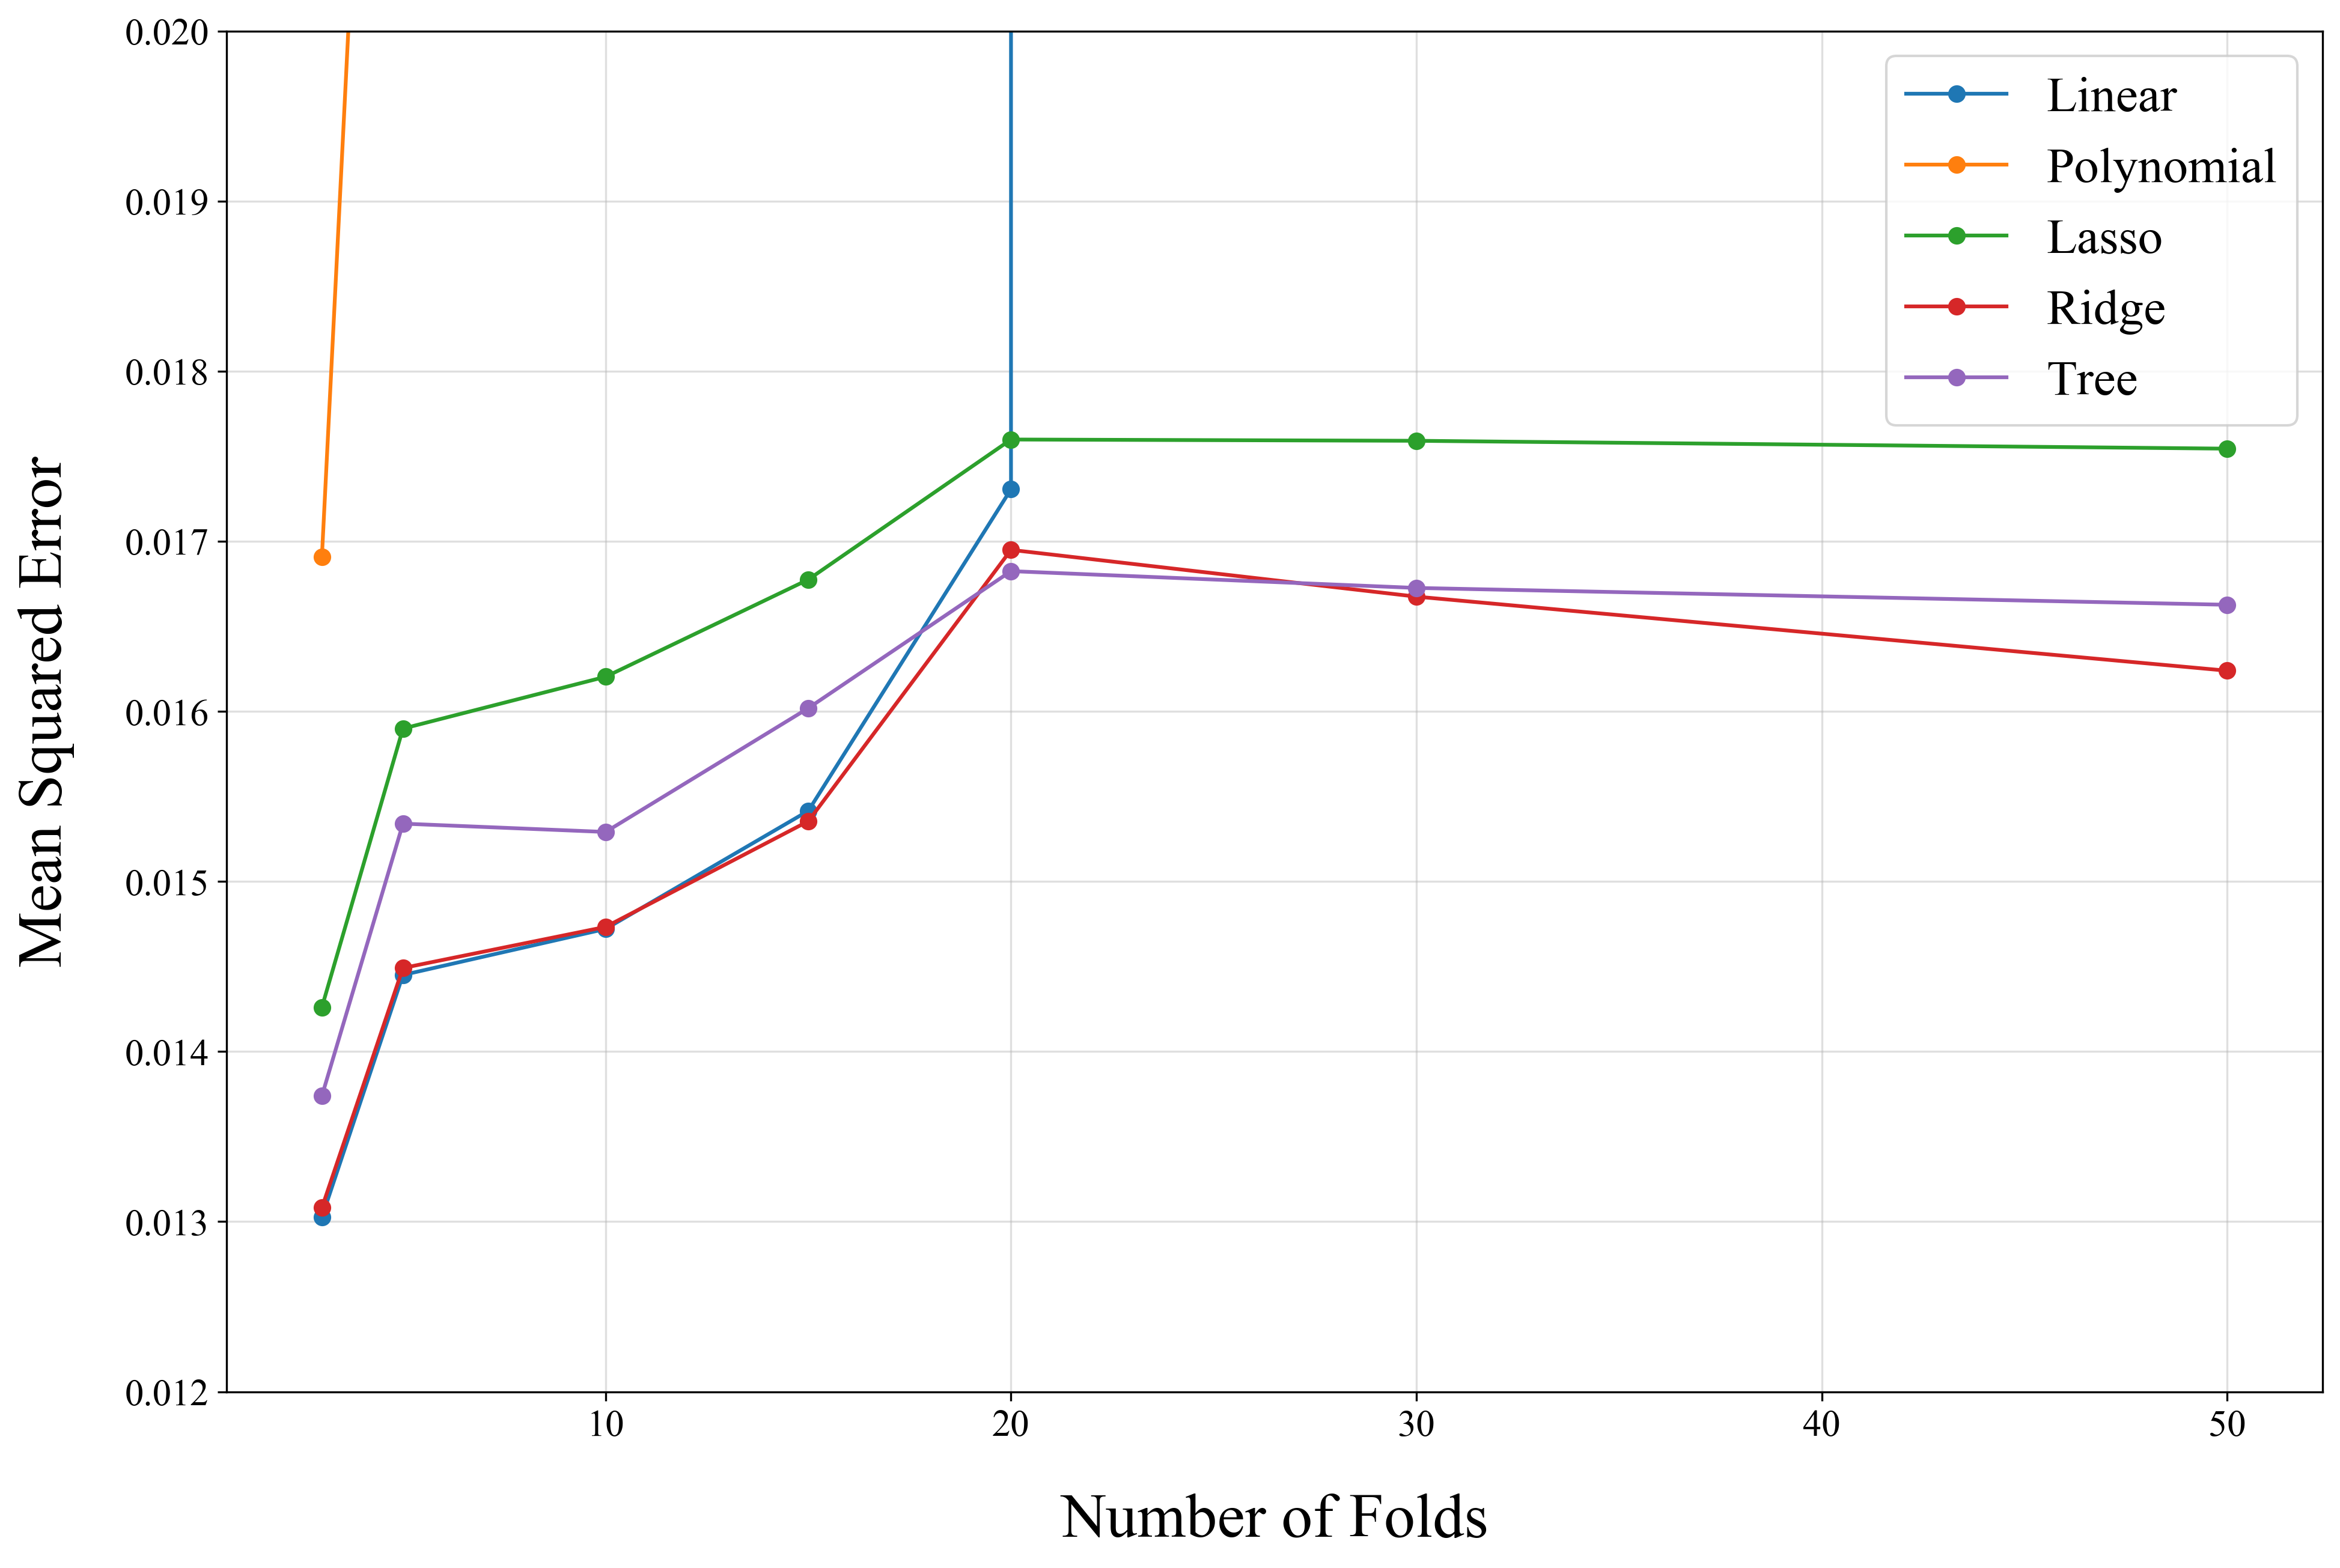

In [308]:
fig, ax = plt.subplots(figsize=[15,10])
ax.set_ylim([0.012, 0.02])
ax.plot(ro_testing_table, marker='o')
ax.legend(ro_testing_table.columns)
ax.set_xlabel('Number of Folds')
ax.set_ylabel('Mean Squared Error')


# Hyperparameter Tuning Graphs

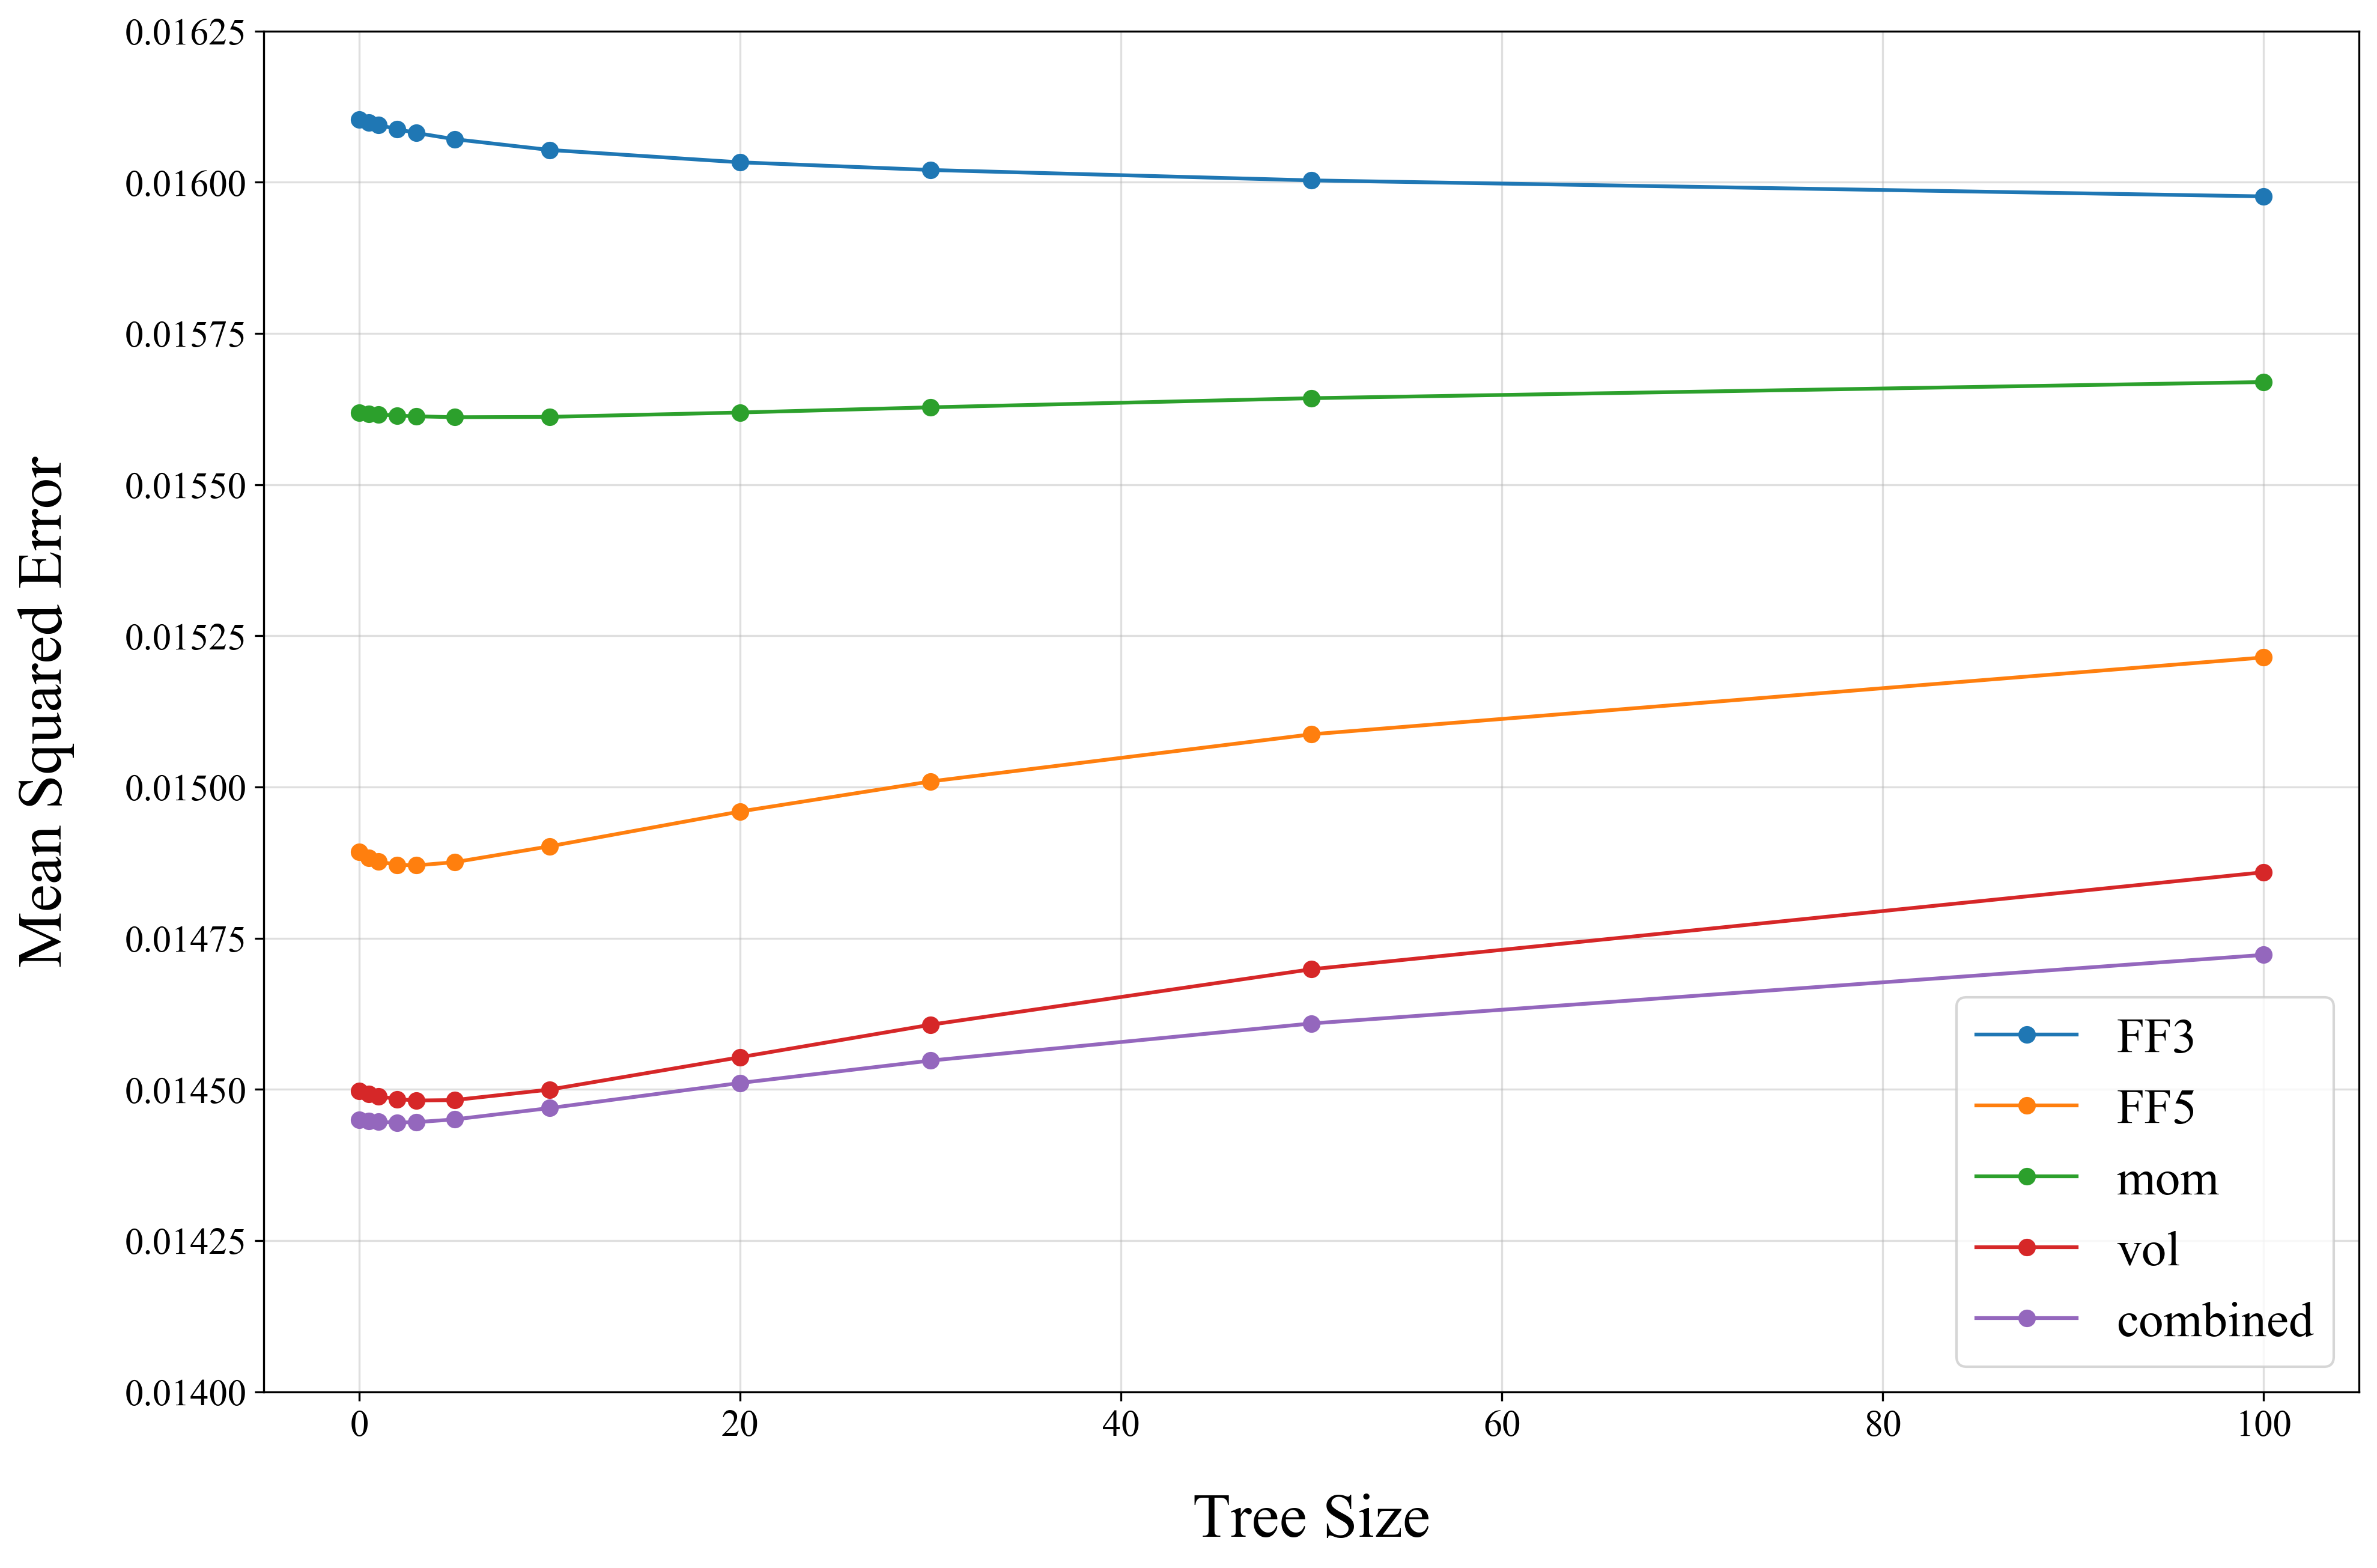

In [314]:
tuning_table = pd.DataFrame(index= [0, 0.5, 1, 2, 3, 5, 10, 20, 30, 50, 100], columns=setups_decomp)

for i in list(tuning_table.index):
    for s in setups_decomp:
        s_ = s
            
        val = rolling_origin_validation(model=Ridge(alpha=i), setup=s_, n_splits=cv, scoring='mean_squared_error')
        tuning_table[s].loc[i] = val

fig, ax = plt.subplots(figsize=[15,10])
ax.set_ylim([0.014, 0.01625])
ax.plot(tuning_table, marker='o')
ax.set_ylabel('Mean Squared Error')
ax.set_xlabel('Tree Size')
plt.legend([i[:-1] for i in tuning_table.columns])

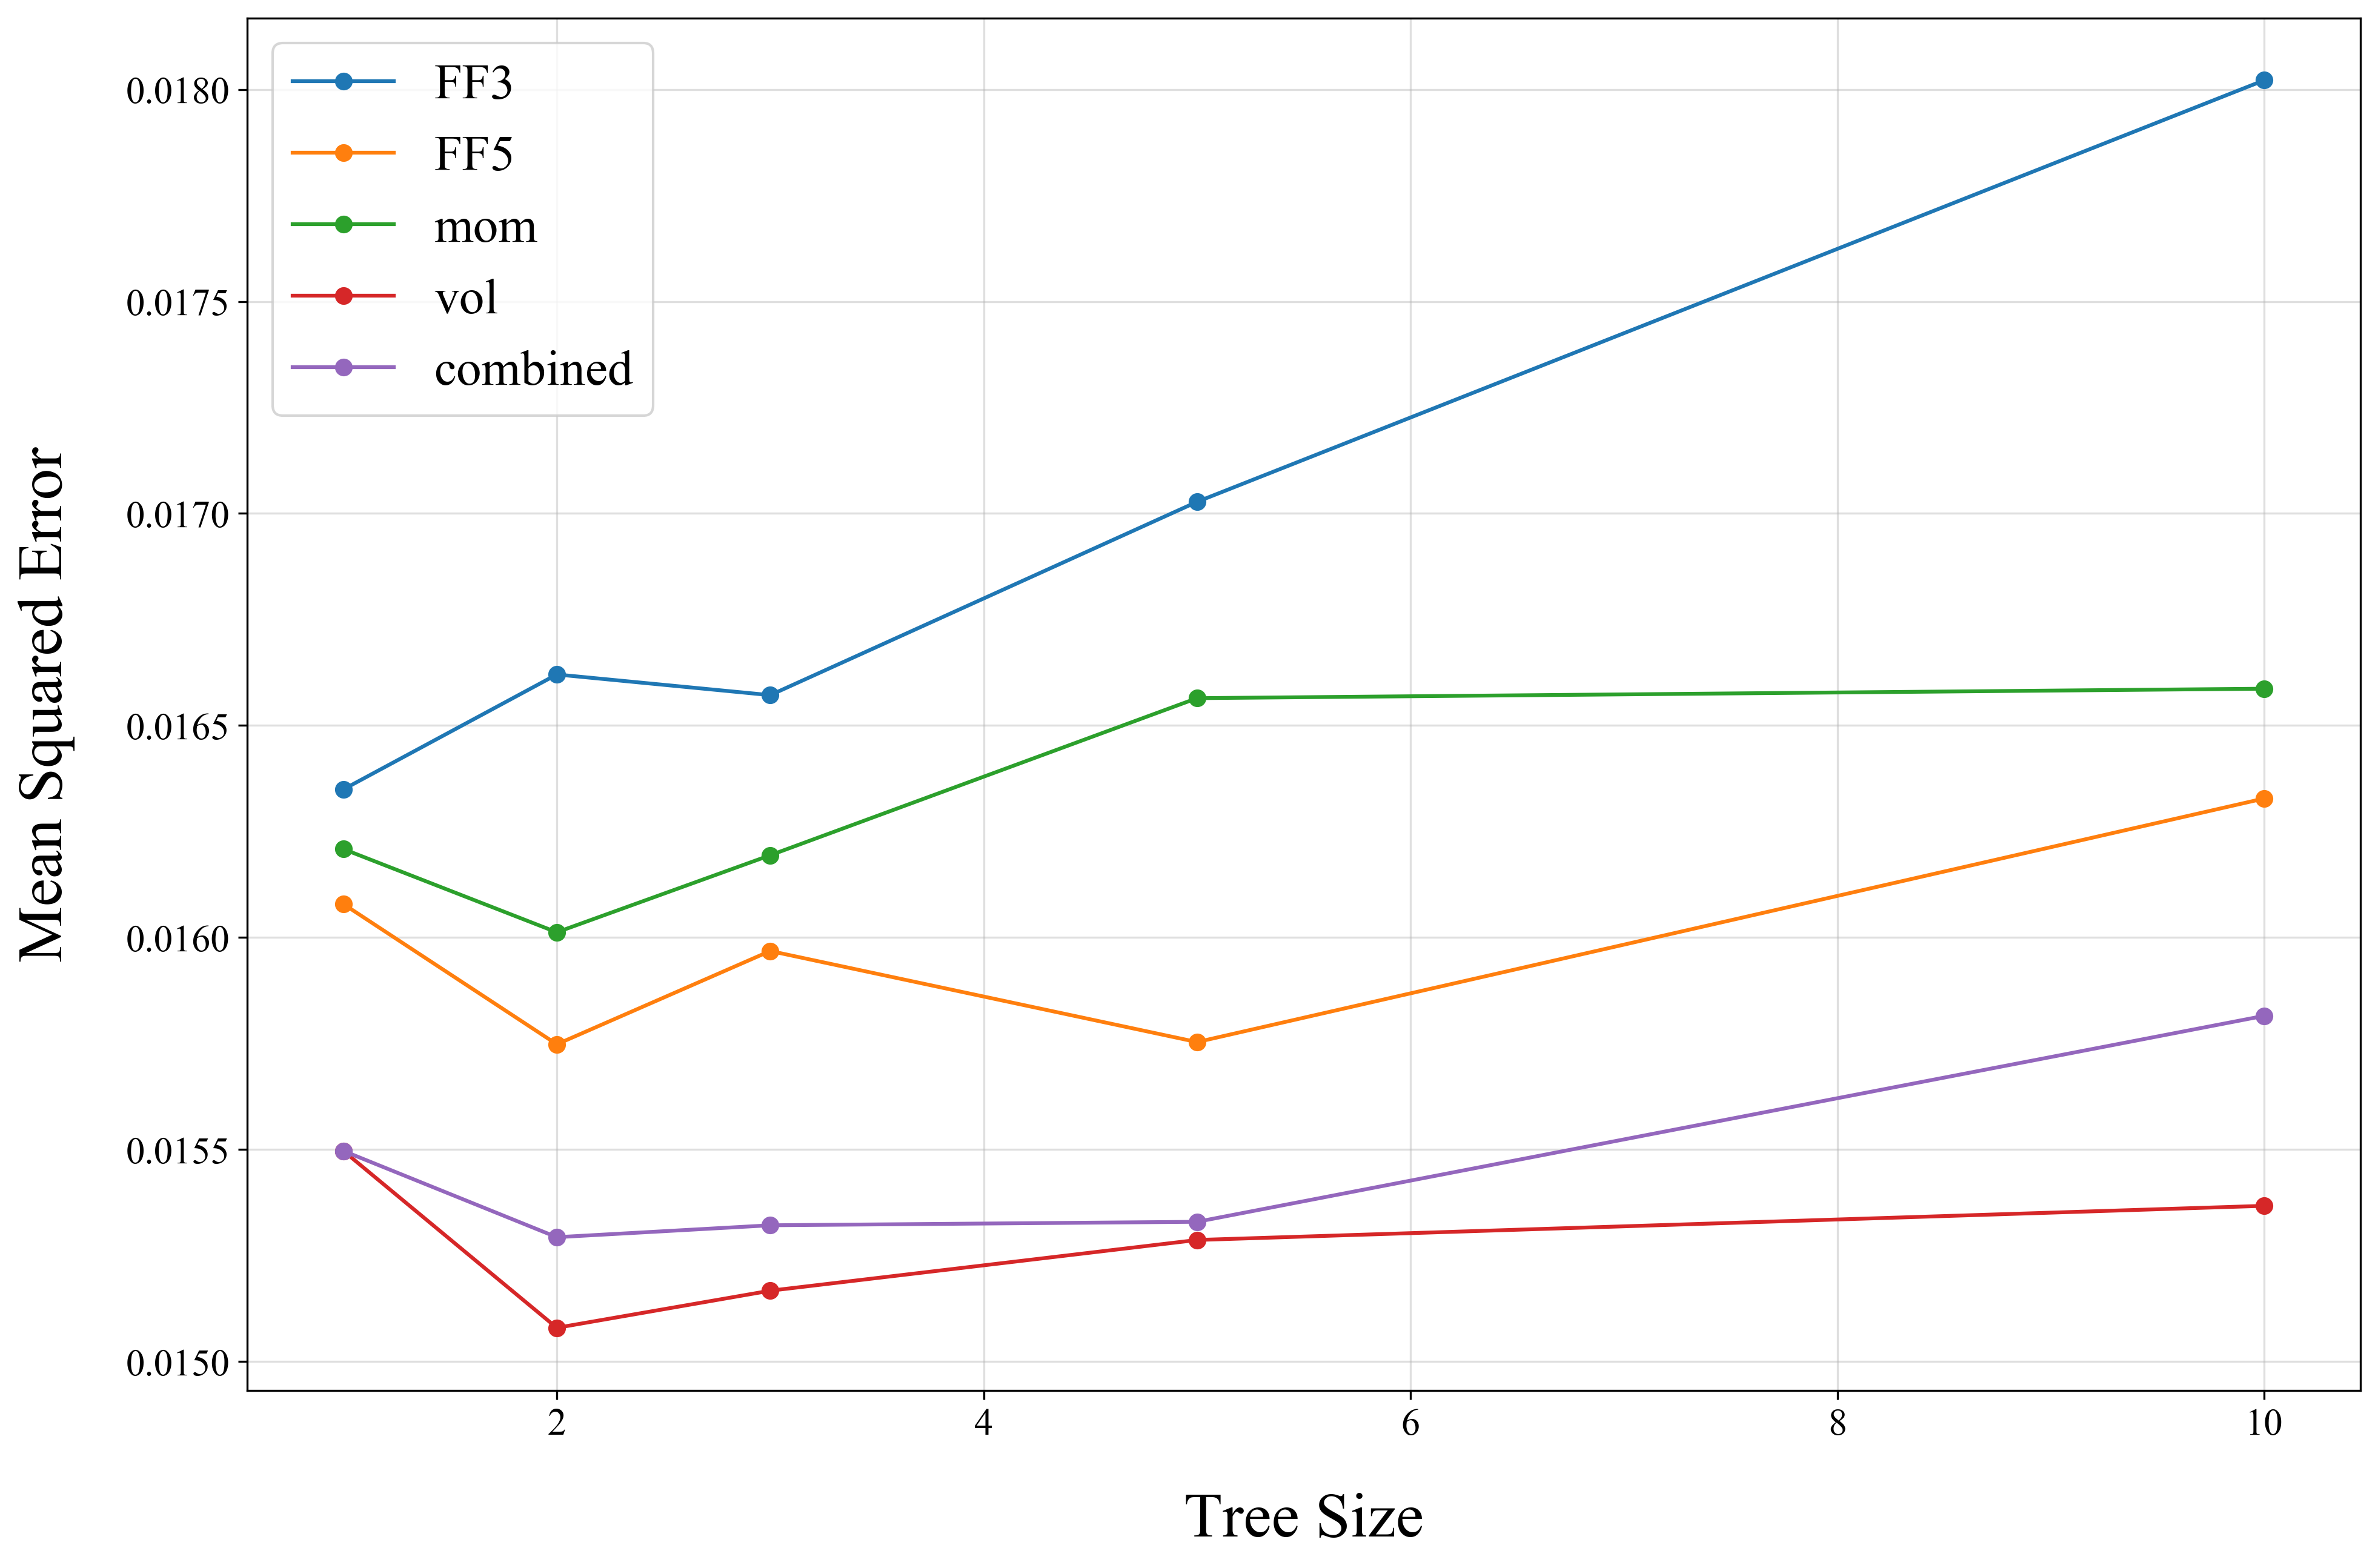

In [313]:
tuning_table = pd.DataFrame(index= [1, 2, 3, 5, 10], columns=setups_decomp)

for i in list(tuning_table.index):
    for s in setups_decomp:
        s_ = s
            
        val = rolling_origin_validation(model=DecisionTreeRegressor(max_depth=i), setup=s_, n_splits=cv, scoring='mean_squared_error')
        tuning_table[s].loc[i] = val

fig, ax = plt.subplots(figsize=[15,10])
# ax.set_ylim([0.014, 0.01625])
ax.plot(tuning_table, marker='o')
ax.set_ylabel('Mean Squared Error')
ax.set_xlabel('Tree Size')
plt.legend([i[:-1] for i in tuning_table.columns])

# Coefficients

In [317]:
coef_setup = 'combined_'

### Average Model From Rolling Origin Evaluation

In [318]:
def ts_validated_reg_table(model, setup, n_splits):
        
    X_ = X[predictor_sets[setup]]
    y_ = y
    
    r2_vals = []
    cols = ['c'] + list(X_.columns)
    coefficients = pd.DataFrame(index=range(n_splits), columns=cols)
    pvals = pd.DataFrame(index=range(n_splits), columns=cols)
    
    splits = TimeSeriesSplit(n_splits=n_splits)
    index = 0
    
    for train_index, test_index in splits.split(X_):

        X_train = X_.loc[train_index]
        X_test = X_.loc[test_index]
        y_train = y_.loc[train_index]
        y_test = y_.loc[test_index]
        
        # Create model
        fitted_model = model.fit(X_train, y_train)
        
        # R-squared values
        pred = fitted_model.predict(X_test)
        r2_val = r2_score(y_test, pred)
        r2_vals.append(r2_val)
        
        # Append coefficients
        
        coefficients.loc[index] = np.array([fitted_model.intercept_] + list(fitted_model.coef_))
        pvals.loc[index] = stats.coef_pval(model, X_train, y_train)
        
        index += 1
    
    average_model = pd.DataFrame({'Coefficient':coefficients.mean(), 'P-Value':pvals.mean()})
    average_model = round(average_model, 3)
    
    return average_model

ols_coefficient_table = ts_validated_reg_table(LinearRegression(), coef_setup, cv)
lasso_coefficient_table = ts_validated_reg_table(Lasso(alpha=2), coef_setup, cv)
ridge_coefficient_table = ts_validated_reg_table(Ridge(alpha=2), coef_setup, cv)

In [319]:
ridge_coefficient_table

,Coefficient,P-Value
c,0.004,0.110
MKT,0.248,0.000
SMB,-0.416,0.000
HML,0.291,0.000
RMW,-0.213,0.091
CMA,0.125,0.124
UMD,-0.114,0.000
VOL,-0.559,0.000


Text(0, 0.5, 'Variable')

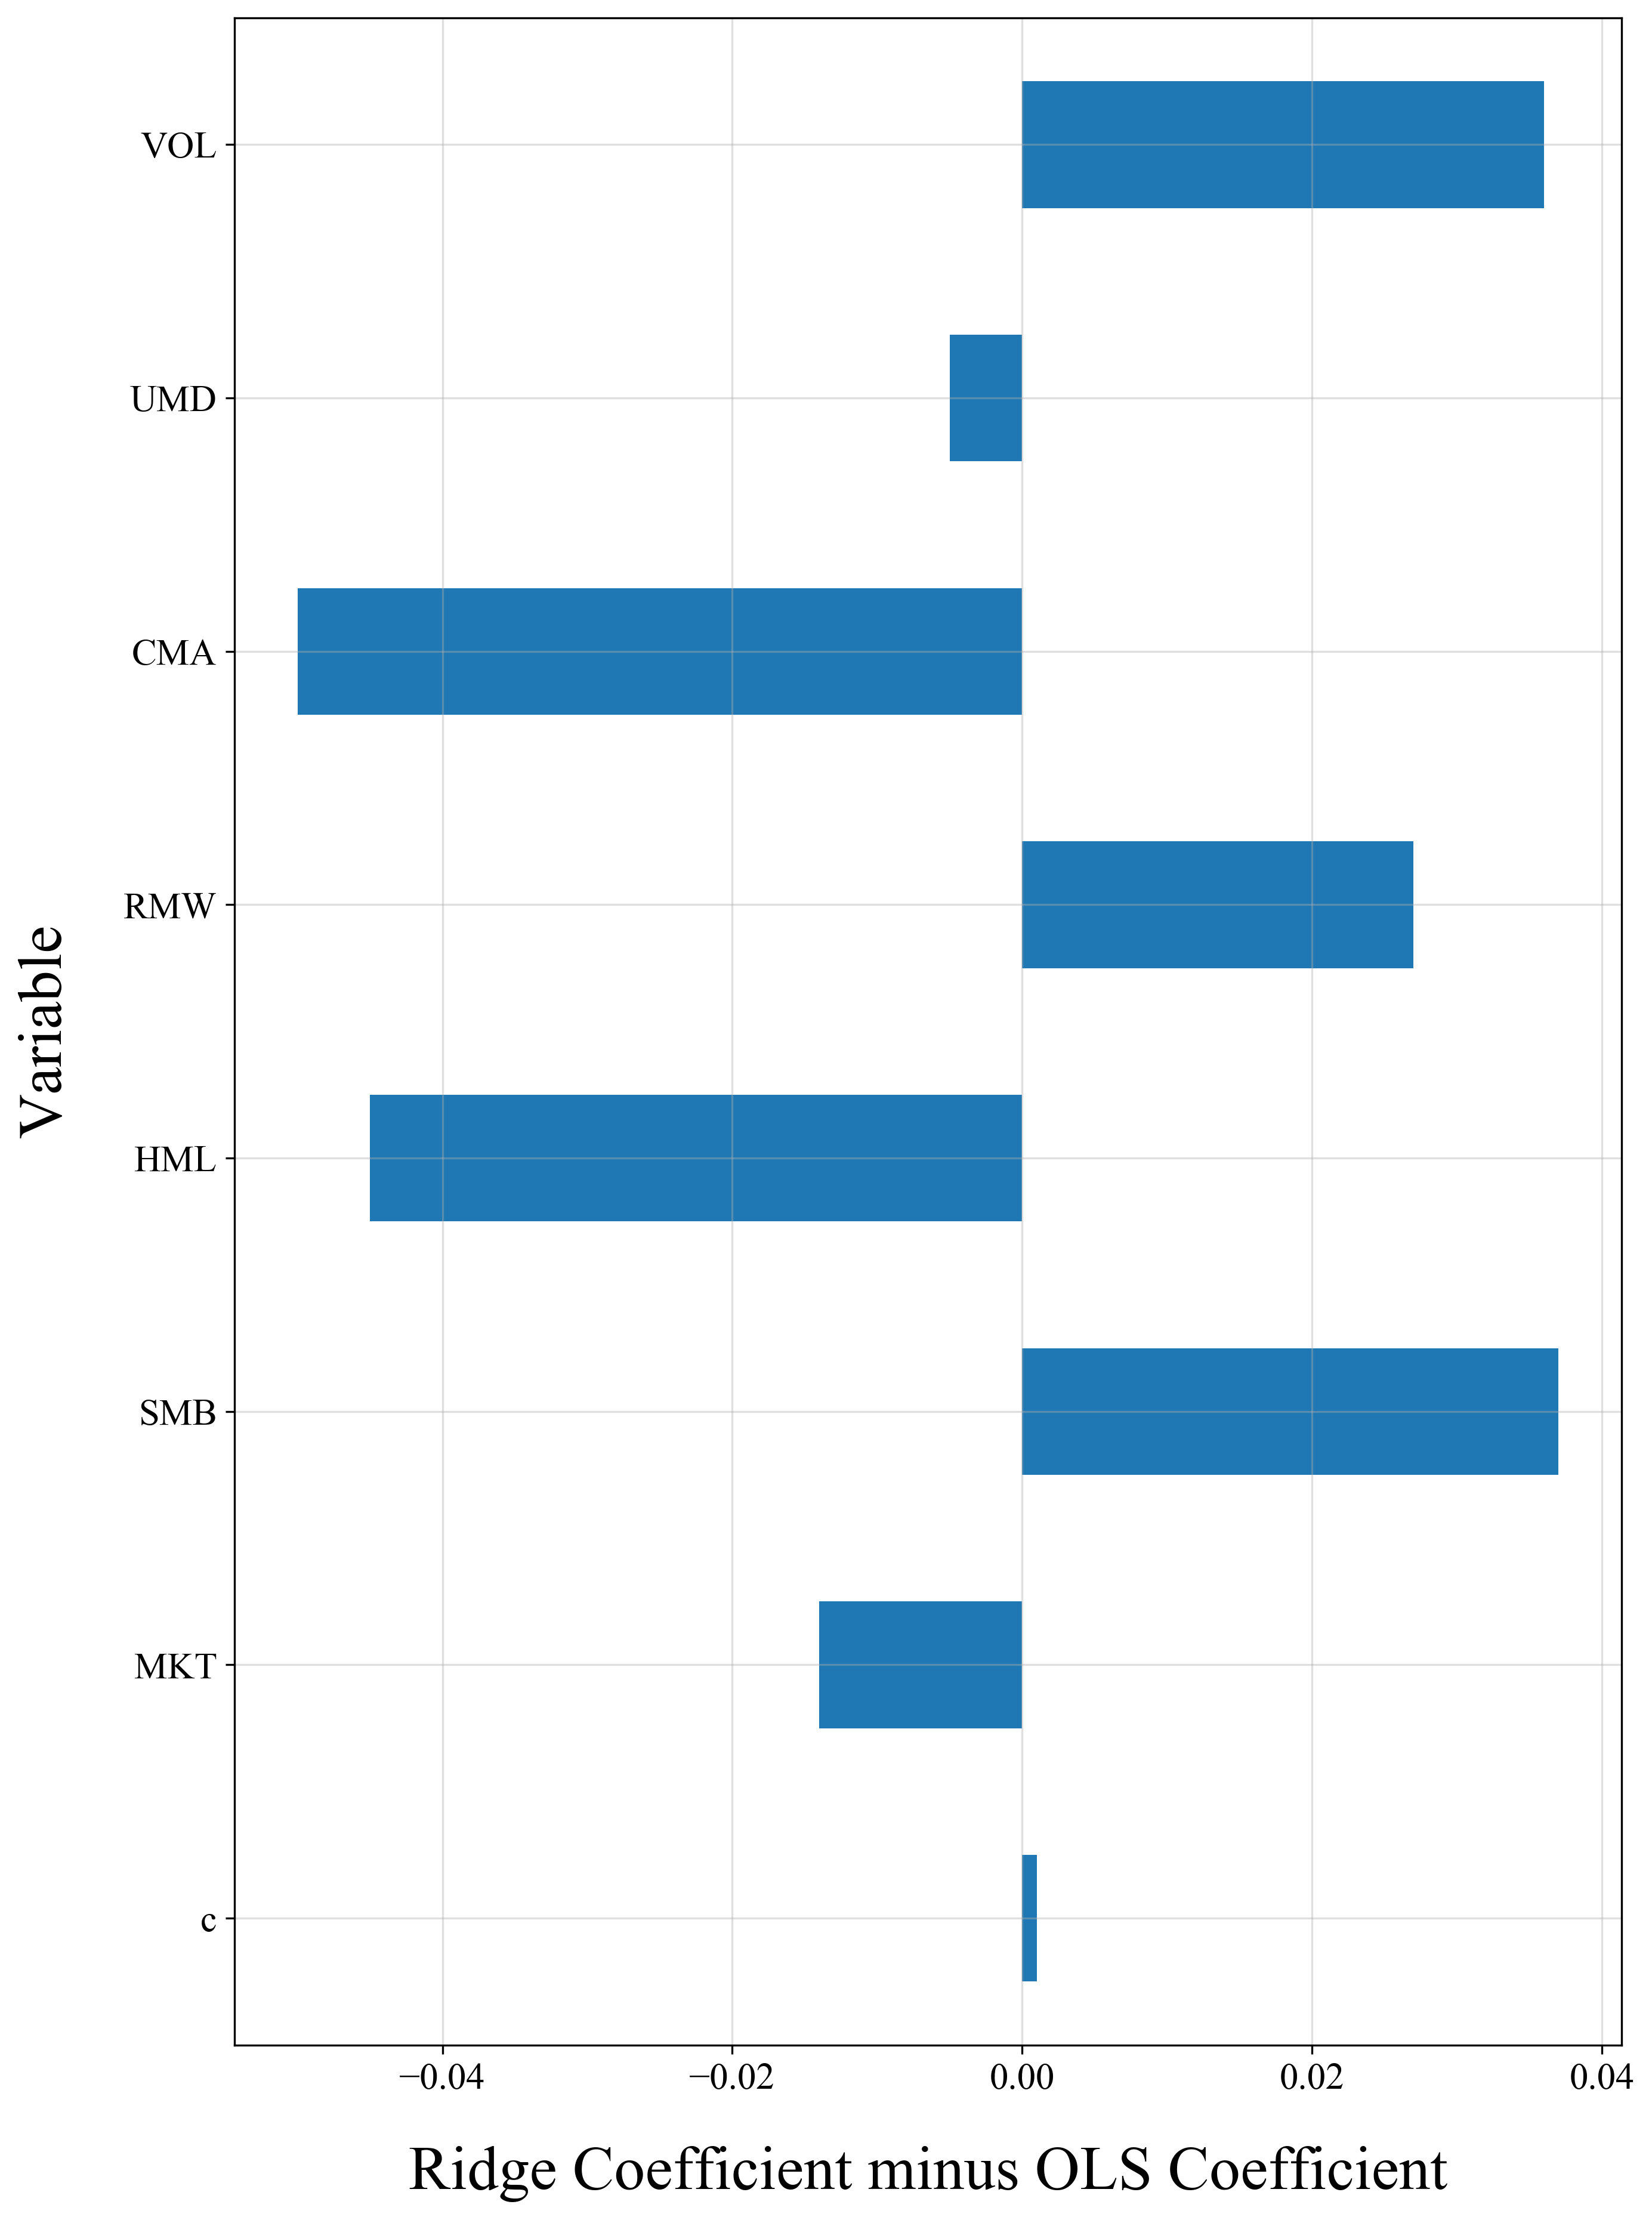

In [320]:

(ridge_coefficient_table['Coefficient'] - ols_coefficient_table['Coefficient']).plot(kind='barh', figsize=[10,15])
plt.xlabel('Ridge Coefficient minus OLS Coefficient')
plt.ylabel('Variable')



[Text(2131.25, 3963.75, 'UMD <= -0.043\nmse = 0.018\nsamples = 136593\nvalue = 0.006'),
 Text(1162.5, 2831.25, 'HML <= 0.269\nmse = 0.028\nsamples = 17239\nvalue = 0.051'),
 Text(775.0, 1698.75, 'SMB <= 0.028\nmse = 0.023\nsamples = 16710\nvalue = 0.044'),
 Text(387.5, 566.25, 'mse = 0.022\nsamples = 9905\nvalue = 0.026'),
 Text(1162.5, 566.25, 'mse = 0.022\nsamples = 6805\nvalue = 0.069'),
 Text(1550.0, 1698.75, 'mse = 0.154\nsamples = 529\nvalue = 0.266'),
 Text(3100.0, 2831.25, 'UMD <= 0.064\nmse = 0.016\nsamples = 119354\nvalue = -0.001'),
 Text(2325.0, 1698.75, 'MKT <= -0.056\nmse = 0.013\nsamples = 103340\nvalue = 0.005'),
 Text(1937.5, 566.25, 'mse = 0.027\nsamples = 7314\nvalue = -0.025'),
 Text(2712.5, 566.25, 'mse = 0.012\nsamples = 96026\nvalue = 0.008'),
 Text(3875.0, 1698.75, 'SMB <= -0.02\nmse = 0.03\nsamples = 16014\nvalue = -0.039'),
 Text(3487.5, 566.25, 'mse = 0.025\nsamples = 4023\nvalue = -0.105'),
 Text(4262.5, 566.25, 'mse = 0.03\nsamples = 11991\nvalue = -0.016')

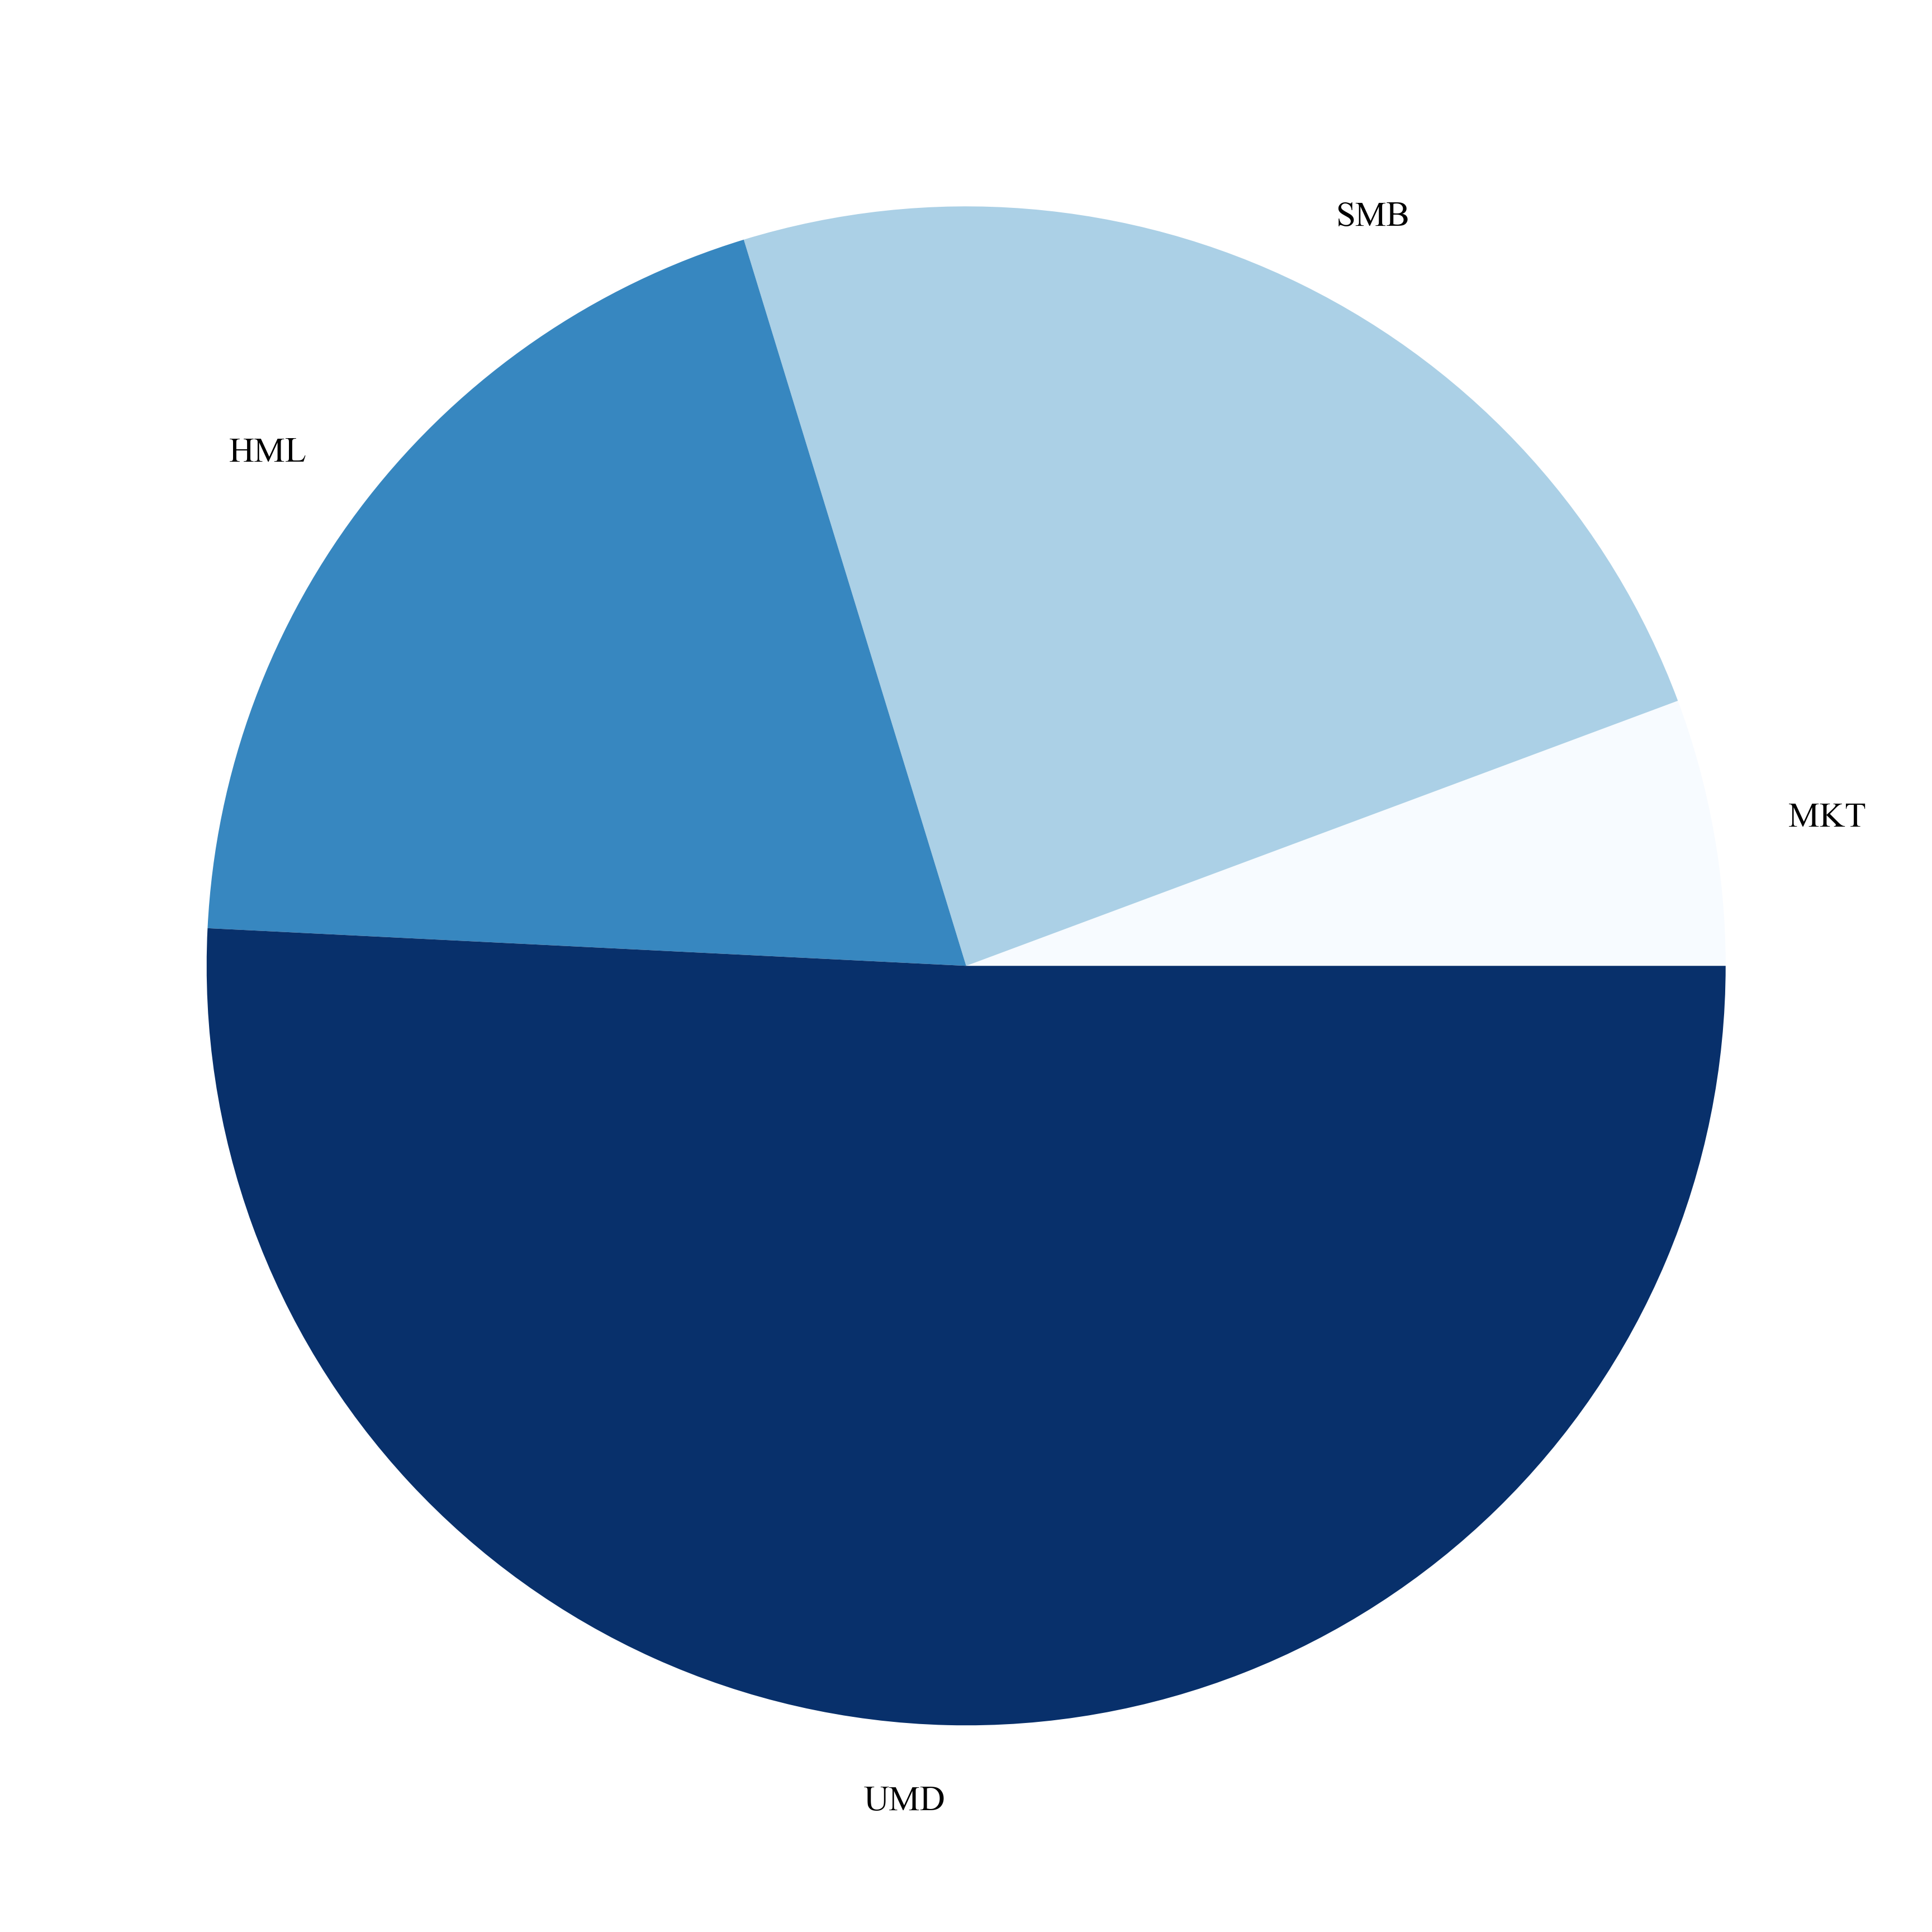

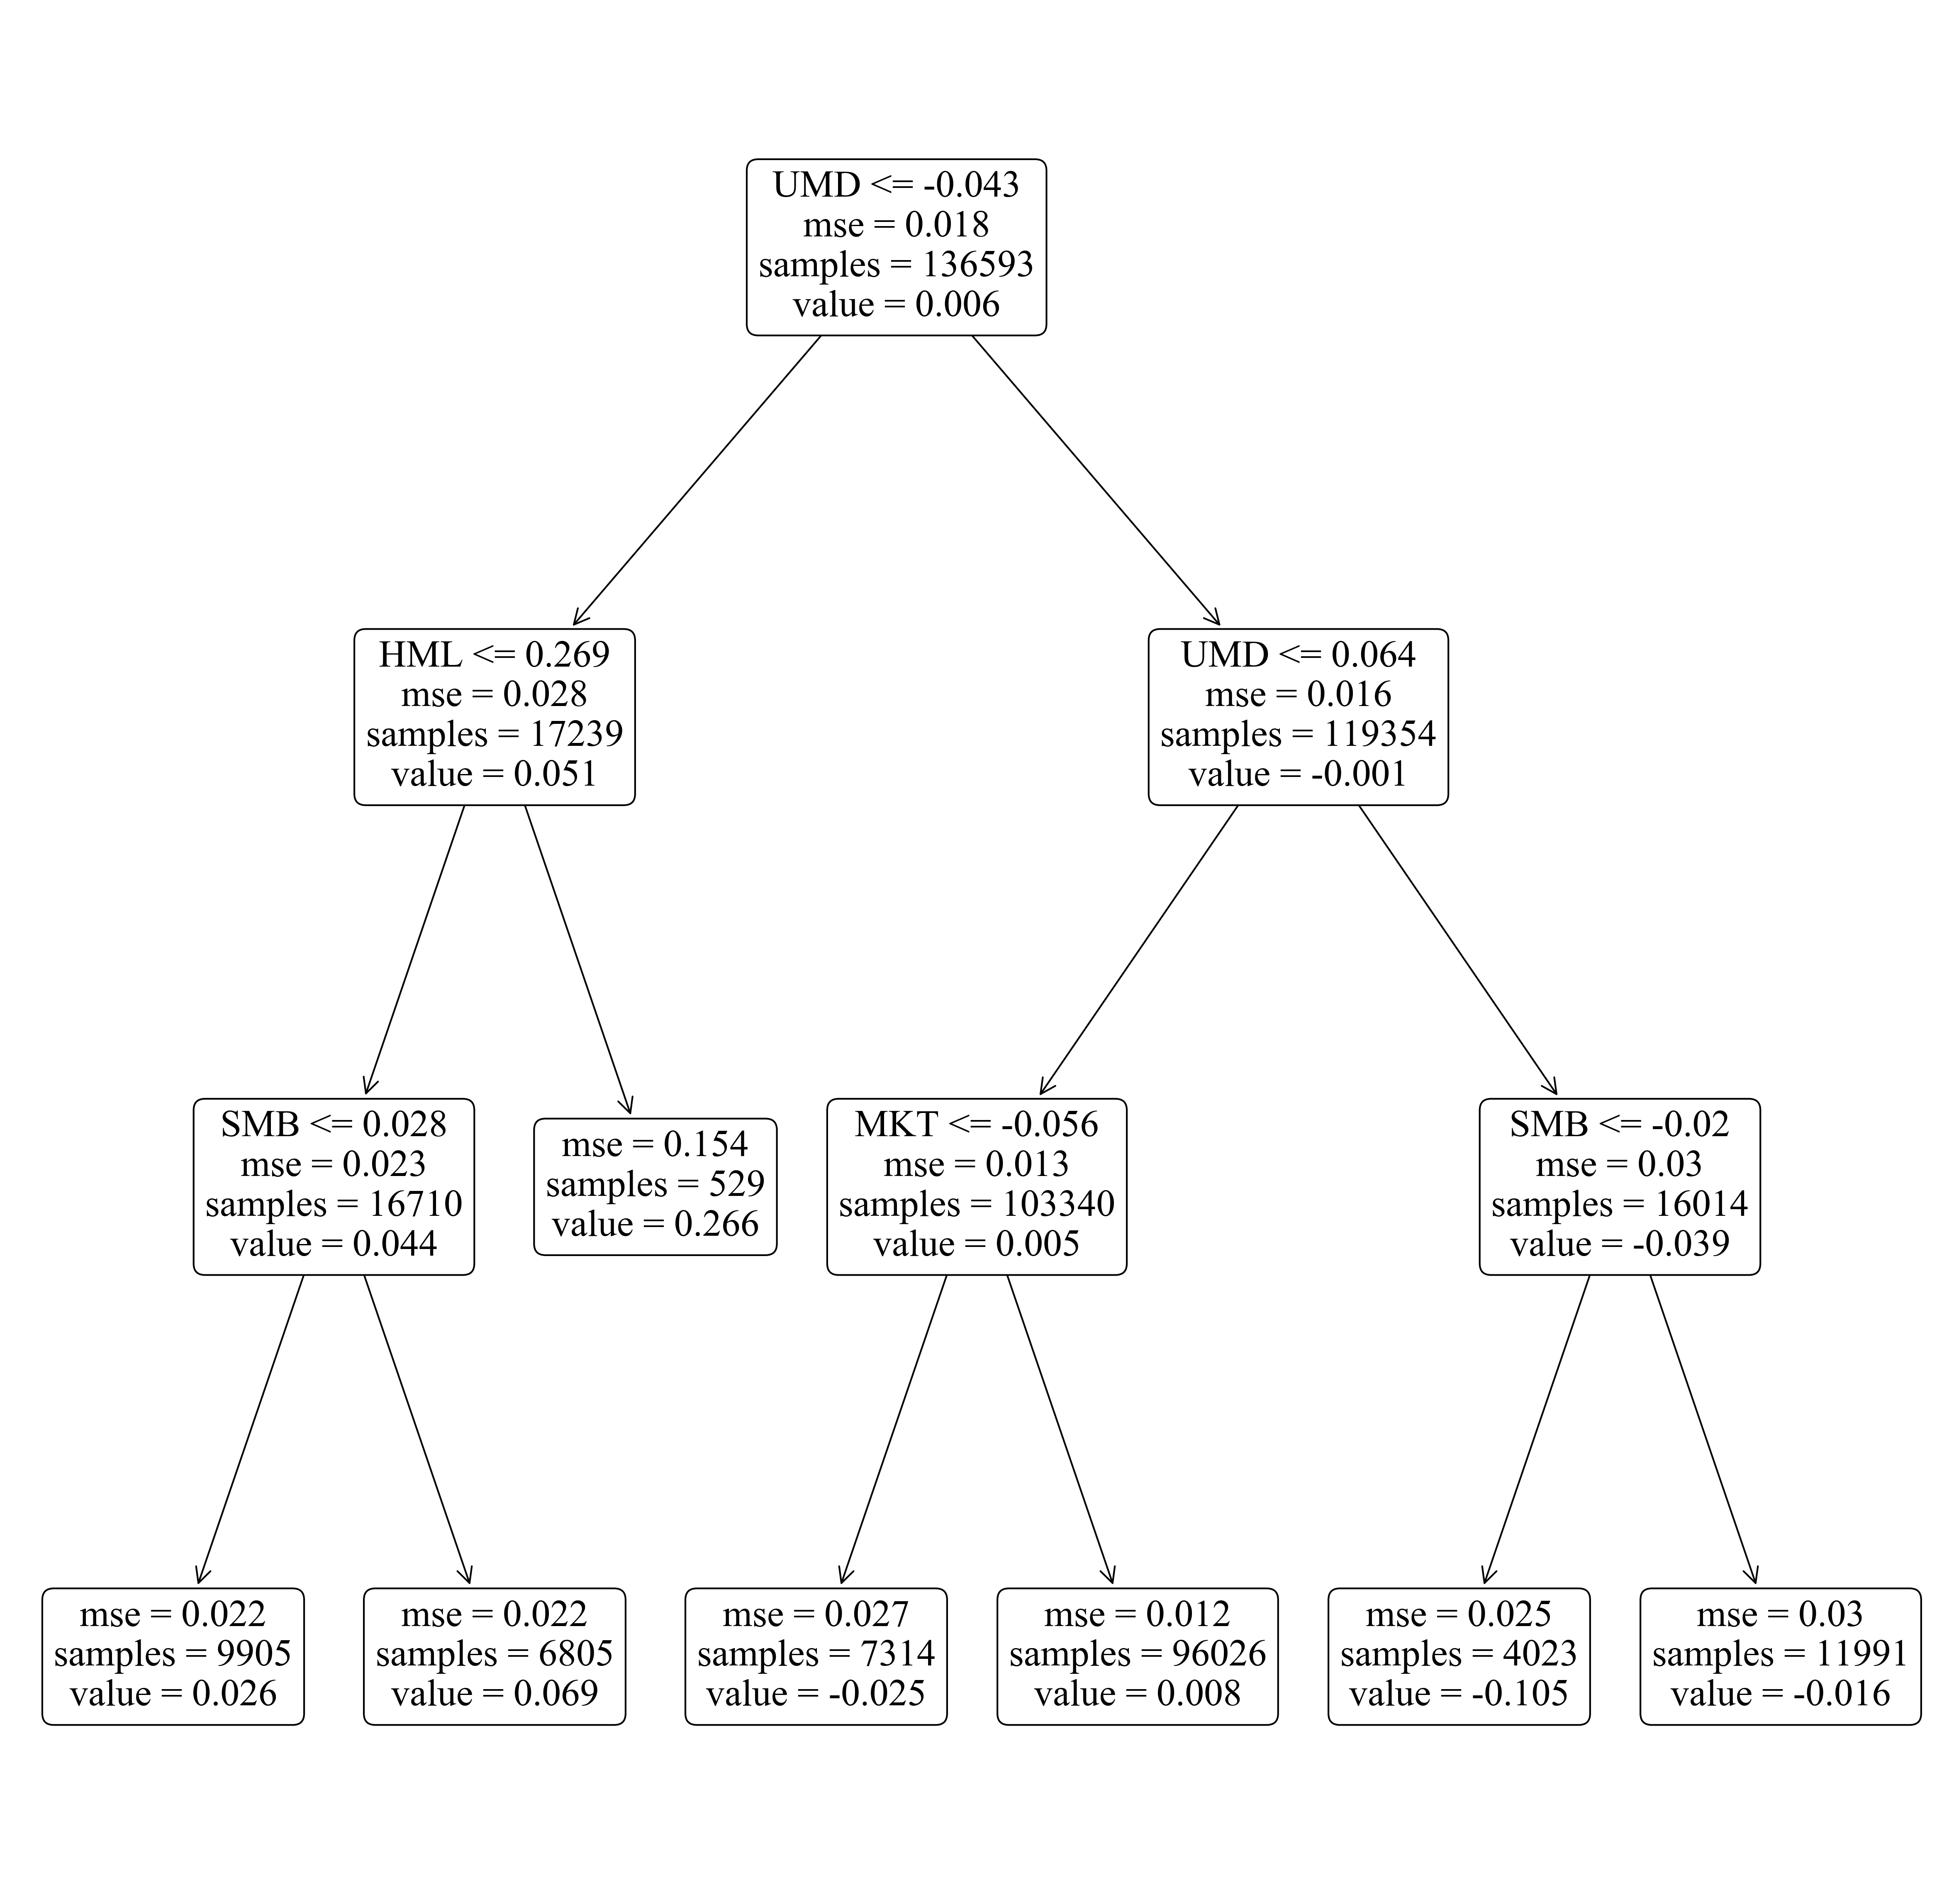

In [305]:
coef_setup = 'mom_'

tree_model = DecisionTreeRegressor(max_depth=3)
tree_model.fit(X[predictor_sets[coef_setup]], y)
tree_coef = pd.DataFrame(index=predictor_sets[coef_setup], data={'Coefficient':tree_model.feature_importances_})

tree_coef.plot(kind='pie', legend=False, figsize=[15,15], subplots=True, cmap='Blues')
plt.ylabel('')

plt.figure(figsize=[20,20])
tree.plot_tree(tree_model, rounded=True, feature_names=predictor_sets[coef_setup], fontsize=22)

# Misc

Kfold   0.061236692778954896
0.08696060699326058
                            OLS Regression Results                            
Dep. Variable:                ret_1f1   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     1858.
Date:                Mon, 30 Mar 2020   Prob (F-statistic):               0.00
Time:                        10:42:18   Log-Likelihood:                 88602.
No. Observations:              136593   AIC:                        -1.772e+05
Df Residuals:                  136585   BIC:                        -1.771e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
con

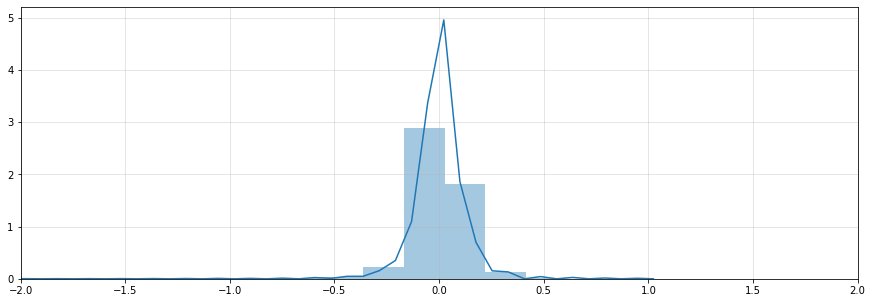

In [195]:
splitter = 0.8

X_train = X#.iloc[: int((splitter) * len(X.index))]
y_train = y#.iloc[: int((splitter) * len(X.index))]
X_test  = X#.iloc[int((splitter) * len(X.index)) : ]
y_test  = y#.iloc[int((splitter) * len(y.index)) : ]

model = 'combined_'

reg = sm.OLS(y_train, sm.add_constant(X_train[predictor_sets[model]])).fit()

print("Kfold  ", np.mean(cross_val_score(estimator=LinearRegression(), X=sm.add_constant(X[predictor_sets[model]]), y=y, scoring=scoring, )))
print(r2_score(y_test, reg.predict(sm.add_constant(X_test[predictor_sets[model]]))))
print(reg.summary())
plt.figure(figsize=[15,5])
plt.xlim([-2,2])
sns.distplot(reg.predict(sm.add_constant(X_test[predictor_sets[model]]))-y_test)
plt.grid(alpha=0.4)
